# Dirichlet Process GMM

In [1]:
import example_gmm
import example_dirichlet as dp
import torch

# Check that the same means and weights were used in the GMM example:
assert torch.equal(dp.true_means, example_gmm.data_means)
assert torch.equal(dp.true_weights, torch.ones((example_gmm.num_mixtures,)) / example_gmm.num_mixtures)

In [2]:
# Load generated data from file:
import pickle

from evaluation import *

runs = []
num_chains = 10
for i in range(num_chains):
    with open(f"samples_produced/dp_mixture_gmm_{i}__count100_eps0.05_leapfrogsteps20.pickle", "rb") as f:
        runs.append(pickle.load(f))

In [3]:
from tqdm import tqdm

# Read Anglican files
for i in tqdm(range(num_chains)):
    for method in anglican_methods:
        runs[i][method] = {}
        with open(f"anglican_samples/dpmm/{method}{i}.txt") as f:
            contents = f.read()
            # Skip parentheses:
            assert contents[0] == "("
            assert contents[-1] == ")"
            contents = contents[1:-1]
            sample_list = contents.split(")]) ([")
            # Skip "([" at the start:
            assert sample_list[0][:2] == "(["
            sample_list[0] = sample_list[0][2:]
            # Skip ")])" at the end:
            assert sample_list[-1][-3:] == ")])"
            sample_list[-1] = sample_list[-1][:-3]
            # Parse each sample:
            def parse_sample(sample_string):
                weights, means = sample_string.split("] [(")
                weights = [float(x) for x in weights.split()]
                means = [[float(x) for x in mean.split()] for mean in means.split(") (")]
                return weights, means

            sample_list = [parse_sample(sample) for sample in sample_list]
            runs[i][method]["samples"] = sample_list

# Read timings:
if anglican_methods:
    timings = parse_anglican_timings("anglican_samples/dpmm/timing.txt")
    for method in anglican_methods:
        for i in range(len(runs)):
            runs[i][method]["time"] = timings[method][i]

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


In [4]:
thinned_runs = thin_runs(all_methods, runs)
chains = collect_chains(all_methods, thinned_runs)
print_running_time(all_methods, runs, thinned_runs)


Running times:
hmc: 1287.31s    1.2873s per sample (after thinning)
is: 285.63s    0.2856s per sample (after thinning)
lmh: 2149.08s    2.1491s per sample (after thinning)
pgibbs: 1785.46s    1.7855s per sample (after thinning)
rmh: 2058.37s    2.0584s per sample (after thinning)
ipmcmc: 369.71s    0.3697s per sample (after thinning)


In [5]:
import torch
import math

# log posterior predictive density
def dp_lppd(samples):
    M = len(samples)
    N = len(dp.test_data)
    #compute the probability density for each data point and sapmle (size M x N):
    log_ps = torch.stack([dp.loglikelihoods(torch.tensor(w), torch.tensor(m), dp.test_data) for w, m in samples])
    # average over all samples:
    logp_avg = torch.logsumexp(log_ps, dim=0) - math.log(float(M))
    # sum over all test data points:
    lppd = torch.sum(logp_avg)
    return lppd

def dp_lppd_stats(chains):
    lppds = torch.tensor([dp_lppd(chain) for chain in chains])
    std, mean = torch.std_mean(lppds)
    return f"{mean.item():.2f} +- {std.item():.2f} (standard deviation)"

print("Log posterior predictive densities:")
print(f"True:  {dp_lppd([(dp.true_weights.tolist(), dp.true_means.tolist())]):.2f}")
for method in all_methods:
    print(f"{method}:  {dp_lppd_stats(chains[method])}")

Log posterior predictive densities:
True:  -674.81
hmc:  -676.29 +- 0.45 (standard deviation)
is:  -739.74 +- 13.40 (standard deviation)
lmh:  -679.24 +- 1.97 (standard deviation)
pgibbs:  -725.96 +- 9.83 (standard deviation)
rmh:  -679.68 +- 2.97 (standard deviation)
ipmcmc:  -713.23 +- 3.67 (standard deviation)


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


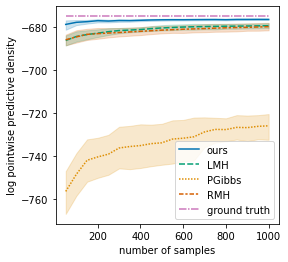

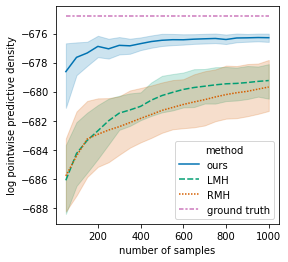

In [6]:
# graph LPPD progression:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
from tqdm import tqdm
lppd_data = []
for i in tqdm(range(1, 21)):
    for method in compared_methods:
        num_chains = len(chains[method])
        num_samples = len(chains[method][0])
        n = i * num_samples // 20
        truncated_lppds = [dp_lppd(chain[:n]).item() for chain in chains[method]]
        lppd_data += [(method_name[method], n * num_chains, lppd) for lppd in truncated_lppds]
    ground_truth = dp_lppd([(dp.true_weights.tolist(), dp.true_means.tolist())]).item()
    lppd_data.append(("ground truth", n * num_chains, ground_truth))
df = pandas.DataFrame(lppd_data, columns=["method", "number of samples", "log pointwise predictive density"])
plt.figure(figsize=(4,4))
plot = sns.lineplot(
    data=df,
    x="number of samples",
    y="log pointwise predictive density",
    hue="method",
    style="method",
    palette=palette,
)
plt.legend(loc="lower right")
plt.show()
plot.get_figure().savefig("dpmm-lppd-plot.pdf", bbox_inches="tight")

df_zoomed_in = pandas.DataFrame([lppd for lppd in lppd_data if lppd[0] in ["ours", "LMH", "RMH", "ground truth"]], columns=["method", "number of samples", "log pointwise predictive density"])
plt.figure(figsize=(4,4))
plot = sns.lineplot(
    data=df_zoomed_in,
    x="number of samples",
    y="log pointwise predictive density",
    hue="method",
    style="method",
    palette=palette,
)
plt.show()
plot.get_figure().savefig("dpmm-lppd-zoomed-in.pdf", bbox_inches="tight")